## Conception :

|Auteur|Centre|Modification|
|---|---|---|
|A. RIGAUT|Arras|2021/01/18|
|B. THIBAULT|Arras|2021/01/18|
|R. VANCAMP|Arras|2021/01/18|
|T. POLY|Arras|2021/01/18|
|V. NAESSENS|Arras|2021/01/18|

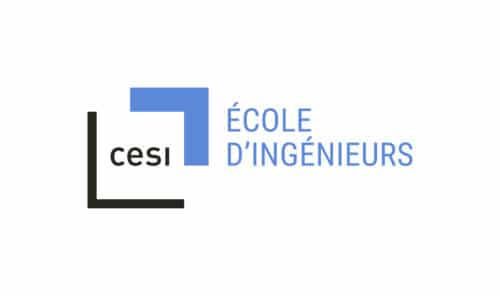





## Contexte

L’entreprise voulant automatiser la sélection de photos pour l’annotations, le livrable 2 devra fournir une méthode de classification se basant sur les réseaux de neurones afin de filtrer les images qui ne sont pas des photos du dataset de départ.

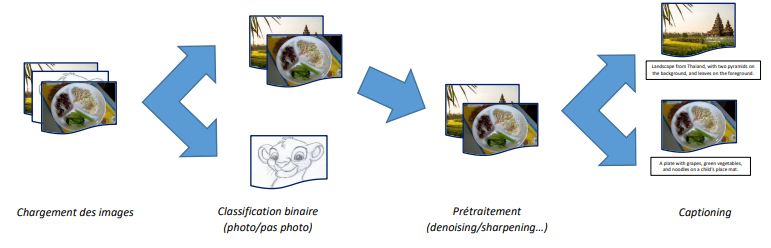

Dans le cas de ce livrable, notre travail se situe au niveau des deux premiers éléments de la chaine. La première partie est le chargement des images depuis un dataset fourni en ressources, qui est composé d'image représentant des peintures, des textes, des photographies et des schémas. La seconde partie est la classification binaire (photo/ pas photo) des images de ce dataset. Pour réaliser cela, nous avons utilisé la librairie TensorFlow ainsi que l'API Keras. 

Ce livrable démontre notre démarche et explique les choix que nous avons fait afin d'atteindre notre objectif.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.io import imread_collection

In [3]:
data_dir = "data/train/"

## Choix relatifs aux performances

En raison de la limite des performances matérielles, nous optons pour un batch de taille 16, car un batch de taille 32 consommait trop de mémoire. De plus, nous avons choisi une taille fixe de 180x180 pour nos images. Certe, nous perdons quelques informations concernant nos images, mais le temps de traitement est largement diminué et la perte d'informtations reste relativement faible.

In [4]:
batch_size = 16
img_height = 180
img_width = 180

## Chargement des images et création du dataset

La méthode _image_dataset_from_directory()_ permet de générer un dataset depuis un dossier d'images. Ce dataset est divisé en classe (Photo, Pas photo), qui permettront à notre algorithme de classifier les images que nous lui fournirons.

Nous utilisons le paramètre "validation_split" afin de diviser notre dataset de la manière suivante :
- 50% du dataset est utilisé pour notre jeu d'entrainement;
- 30% du dataset est utilisé pour notre jeu de test;
- 20% du dataset est utilisé pour la validation de notre modèle.



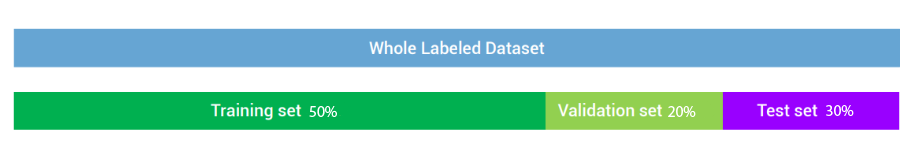

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.5,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 28996 files belonging to 2 classes.
Using 14498 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 28996 files belonging to 2 classes.
Using 8698 files for validation.


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 28996 files belonging to 2 classes.
Using 5799 files for validation.


## Récupération des classes

Ici, nous récupérons les différentes classes correspondant à l'arborescence de notre dataset.

In [8]:
class_names = train_ds.class_names
print(class_names)

['NoPhoto', 'photo']


## Prise de connaissance du dataset

Nous affichons aléatoirement des images récupérées ainsi que la classe correpondante depuis nos différents dossier.

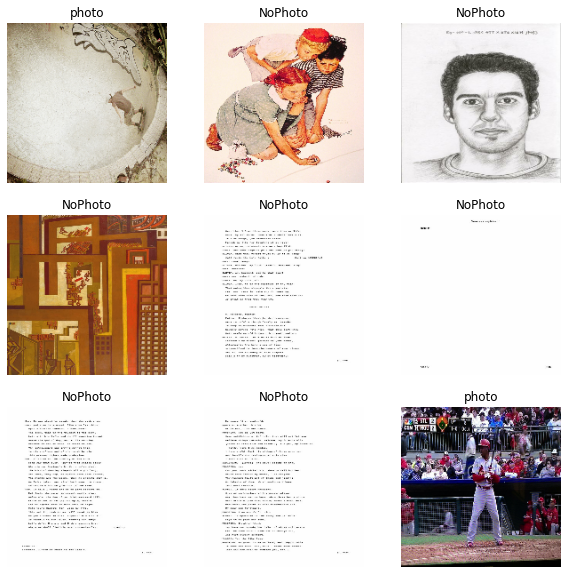

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

L' image_batch est un tenseur de la forme (16, 180, 180, 3) . Il s'agit d'un lot de 16 images de forme 180x180x3 (la dernière dimension fait référence aux canaux de couleur RVB). Le _label_batch_ est un tenseur de la forme (16,) , ce sont des labels correspondants aux 16 images.

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 180, 180, 3)
(16,)


## Configuration de la gestion des données

Nous utilisons la prélecture tamponnée afin de pouvoir générer des données à partir du disque sans que les E / S deviennent bloquantes. Ce sont deux méthodes importantes que nous utilisons lors du chargement des données.  

_Dataset.cache()_ garde les images en mémoire après leur chargement hors du disque au cours de la première époque. Cela garantira que l'ensemble de données ne deviendra pas un goulot d'étranglement lors de l'entraînement de notre modèle.

_Dataset.prefetch()_ chevauche le prétraitement des données et l'exécution du modèle pendant l'entraînement.  

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardisation des données

Les valeurs de canal RVB sont dans la plage [0, 255] . Ce n'est pas idéal pour un réseau neuronal. Ici, nous normalisons les valeurs pour qu'elles soient dans la plage [0, 1] en utilisant un calque de redimensionnement.

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Création du modèle & paramétrage du réseau

_num_classes=2_ correspond aux 2 classes de notre dataset (Photo, Pas photo).

Le modèle se compose de cinq blocs de convolution avec une couche de pool maximale dans chacun d'eux. Il y a une couche entièrement connectée avec 128 unités au-dessus qui est activée par une fonction d'activation relu.

La fonction d'activation la plus utilisée de nos jours est la ReLU - Rectified Linear Unit - qui est une fonction linéaire par morceaux. Son avantage réside sur le fait qu'elle remplace toute valeur d'entrée négative par 0 et toute valeur positive par elle même, en gros max(0,x). Et pour son gradient, il devient nul pour les valeurs négatives et vaut 1 pour les valeurs positives. Cette propriété est très intéressante dans la phase d'apprentissage car elle permet d'éviter et de corriger le problème du vanishing gradient. Mais sa principale limitation est que certains gradients peuvent être fragiles et donc mourir (s'annuler) et cela est du à sa valeur nulle pour des valeurs négatives.

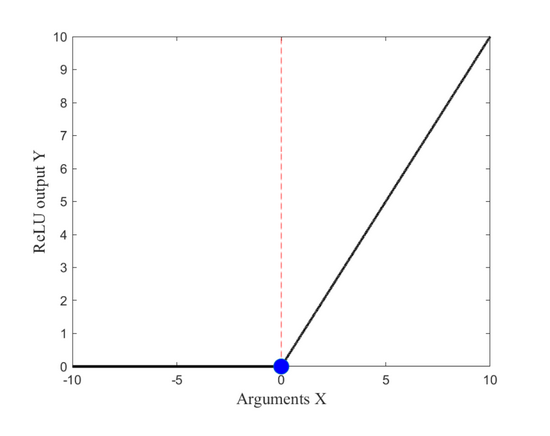

Le paramètre "padding=same" permet de s'assurer que les dimensions de l'image de sortie soient similaires à celles des images fournies.

Enfin, nous avons rajouté une dernière couche entièrement connectée (Dense) permettant de relier le résultat de sortie aux 2 neurones correspondant à nos 2 classes de classification.

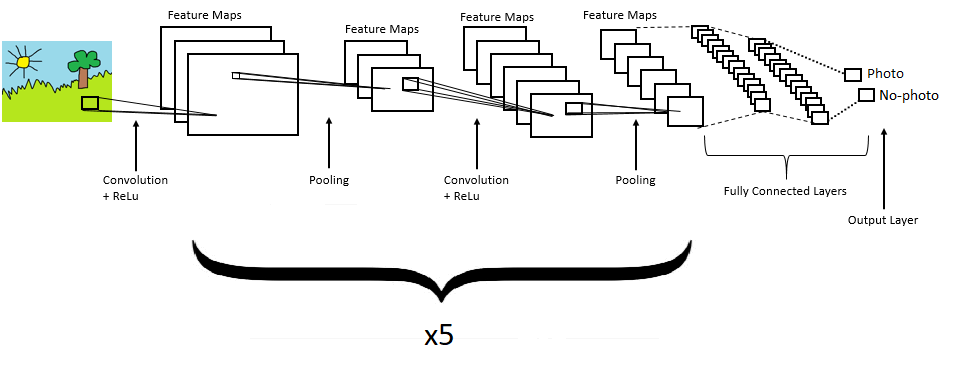


In [15]:
num_classes = 2

modelFinal = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(3, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

## Compilation du modèle

### L'optimiseur

Lors de la compilation du modèle, nous utilisons l'optimiseur Adam (Adaptative Momentum Estimation). Il s'agit de l'optimiseur le plus utilisé pour les réseaux de neurones en raison de son efficacité et de sa stabilité. Adam est un algorithme d'optimisation qui peut être utilisé à la place de la procédure classique de descente de gradient stochastique pour mettre à jour les poids de réseau itératifs en fonction des données d'apprentissage.

Il présente divers avantages qui sont :
- Simple à mettre en œuvre.
- Efficace en termes de calcul.
- Peu de mémoire requise.
- Invariant à la remise à l'échelle diagonale des dégradés.
- Bien adapté aux problèmes importants en termes de données et / ou de paramètres.
- Convient aux objectifs non stationnaires.
- Convient aux problèmes avec des gradients très bruyants / ou clairsemés.
- Les hyper-paramètres ont une interprétation intuitive et nécessitent généralement peu de réglages.

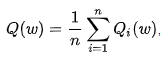

### La fonction objectif

Le but des fonctions de objectif est de déterminer mathématiquement la qualité de la réponse d'un problème donné. On vise donc a la maximiser ou à la minimiser. Dans le cas de notre modèle, nous cherchons à maximiser la fonction _SparseCategoricalCrossentropy_. En effet celle si calcul l'entropie croisée (Cross entropy), qui est en fait la mesure de différence entre notre prédiction et la réalité. 

Le paramètre __from_logits=true__ permet de s'assurer que notre prédiction est un Logit c'est à dire que les probabilité allant de [0, 1] sont rédéfini sur un enssemble appartenant à R.

La fonction _summary()_ permet d'exposer une vue d'ensemble de notre modèle.

In [16]:
modelFinal.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
modelFinal.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 3)       84        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Formation & sauvegarde du modèle

La fonction _model.fit()_ permet d'entraîner notre modèle. Pour ce faire, nous définissons plusieurs paramètres :
- train_ds correspond à notre dataset d'entraînement, que nous avons défini plus haut.
- validation_data correspond à notre dataset de validation
- epochs correspond aux nombre de fois que l'algorithme va effectuer un passage sur l'ensemble des données fournies. Ici, nous définissons le nombre d'épochs sur 10 pour des raisons de limite matérielle. En effet, plus le nombre d'epochs est grand, plus le modèle est performant, mais plus il demande une puissance de calcule élevée. 

Il est possible de sauvegarder notre modèle pour ne plus avoir à l'entraîner à chaque fois que nous souhaitons l'utiliser, en utilisant la fonction _Save()_

In [18]:
epochs=10
history = modelFinal.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
907/907 [==============================] - 90s 99ms/step - loss: 0.3784 - accuracy: 0.7960 - val_loss: 0.3183 - val_accuracy: 0.8571 - loss: 0.4829 - accuracy: - ETA: 17s - loss: 0.4711 - accuracy: 0.705 - ETA: 17s - loss: 0.4695 - accuracy: 0.707 - ETA: 16s - loss: 0.4696 - accuracy: - ETA: 16s - loss: 0.4 - ETA: 14s - loss: 0.4357 - accuracy: 0.738 - ETA: 14s - loss: 
Epoch 2/10
907/907 [==============================] - 23s 25ms/step - loss: 0.3111 - accuracy: 0.8539 - val_loss: 0.3933 - val_accuracy: 0.7916
Epoch 3/10
907/907 [==============================] - 23s 25ms/step - loss: 0.2735 - accuracy: 0.8772 - val_loss: 0.2775 - val_accuracy: 0.8818 ETA: 14s - loss: 0.2856 - accuracy: 0. - ETA: 13s -  - ETA: 2s - loss: 0 - ETA: 1s - loss: 0.2736 
Epoch 4/10
907/907 [==============================] - 23s 25ms/step - loss: 0.2483 - accuracy: 0.8888 - val_loss: 0.2643 - val_accuracy: 0.8848
Epoch 5/10
907/907 [==============================] - 23s 25ms/step - loss: 0.2261 - 

In [19]:
modelFinal.save('saved_model/modelFinal')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/modelFinal\assets


## Analyse des performances du modèle 

Dans cette partie, nous comparons les performances de notre modèle. Dans un premier temps, nous évaluons la précision de notre modèle, puis dans un second, nous évaluons les pertes.

Comme vous pouvez le constater, il y a une fracture à partir de l'epoch 6. Nous observons une chute importante de la précision, et donc en conséquence une augmentation significative de la fonction de perte. Cela prouve que nous n'entraînons pas assez notre algorithme, et qu'il faudrait augmenter le nombre d'epochs afin d'obtenir une meilleure précision.

La fonction _Softmax()_ permet de transofrmer un vecteur de valeurs en un vecteur de probabilités.


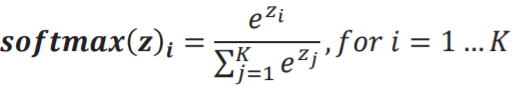

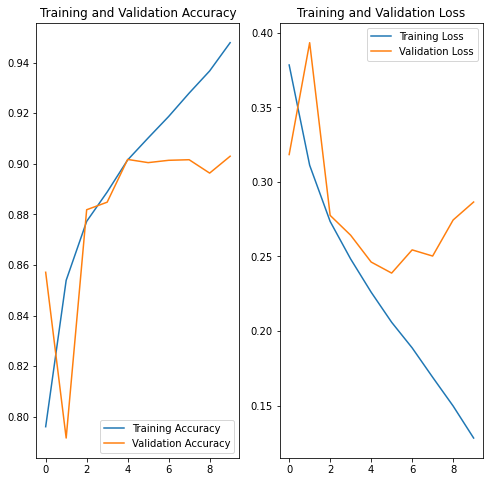

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [4]:
model_saved = tf.keras.models.load_model('saved_model/modelFinal')

# Check its architecture
model_saved.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 3)       84        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [5]:
probability_model = tf.keras.Sequential([model_saved, tf.keras.layers.Softmax()])

# Prédiction

Nous souhaitons ici utiliser notre modèle une fois entraîner.

Pour ce faire, nous fournissons une image grâce à la fonction _imread_collection()_, puis nous redimensionnons celle-ci afin qu'elle corresponde aux paramètres de notre modèle, puis nous prédisons sa classe à l'aide de la foncrion _predict()_.

Afin de récupérer le nom (label) de notre classe, nous utilisons le nom des classes sauvegardées lors du chargement du dataset de départ, puis  nous utilisons la fonction _argmax()_ qui récupère l'index de la plus grande probabilité correspondant à l'appartenance à une classe.

In [6]:
dataTest = imread_collection('data/test/*.jpg')

In [7]:
imgModif = cv2.resize(dataTest[2],(180,180))
imgModif = np.reshape(imgModif,[1,180,180,3])

plt.axis("off")
plt.imshow(dataTest[2])
plt.show()

IndexError: There are only 0 images in the collection

In [39]:
predictions = probability_model.predict(imgModif)
class_names[np.argmax(predictions[0])]

'photo'